In [1]:
import pandas as pd 

df = pd.read_csv(
    "../data/household_power_consumption.txt",
    sep = ";",
    low_memory=False
)

In [2]:
df.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


In [4]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 9 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Date                   str    
 1   Time                   str    
 2   Global_active_power    str    
 3   Global_reactive_power  str    
 4   Voltage                str    
 5   Global_intensity       str    
 6   Sub_metering_1         str    
 7   Sub_metering_2         str    
 8   Sub_metering_3         float64
dtypes: float64(1), str(8)
memory usage: 142.5 MB


In [5]:
df.describe()

,Sub_metering_3
count,2.049280e+06
mean,6.458447e+00
std,8.437154e+00
min,0.000000e+00
25%,0.000000e+00
50%,1.000000e+00
75%,1.700000e+01
max,3.100000e+01


In [6]:
df.replace("?", pd.NA, inplace=True)

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0
...,...,...,...,...,...,...,...,...,...
2075254,26/11/2010,20:58:00,0.946,0.000,240.430,4.000,0.000,0.000,0.0
2075255,26/11/2010,20:59:00,0.944,0.000,240.000,4.000,0.000,0.000,0.0
2075256,26/11/2010,21:00:00,0.938,0.000,239.820,3.800,0.000,0.000,0.0
2075257,26/11/2010,21:01:00,0.934,0.000,239.700,3.800,0.000,0.000,0.0


In [7]:
df.isna().sum()

Date                         0
Time                         0
Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64

In [8]:
numeric_cols = [
    "Global_active_power",
    "Global_reactive_power",
    "Voltage",
    "Global_intensity",
    "Sub_metering_1",
    "Sub_metering_2",
    "Sub_metering_3"
]

df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric)

In [9]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 9 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Date                   str    
 1   Time                   str    
 2   Global_active_power    float64
 3   Global_reactive_power  float64
 4   Voltage                float64
 5   Global_intensity       float64
 6   Sub_metering_1         float64
 7   Sub_metering_2         float64
 8   Sub_metering_3         float64
dtypes: float64(7), str(2)
memory usage: 142.5 MB


In [10]:
df.ffill(inplace=True)


,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0
...,...,...,...,...,...,...,...,...,...
2075254,26/11/2010,20:58:00,0.946,0.000,240.43,4.0,0.0,0.0,0.0
2075255,26/11/2010,20:59:00,0.944,0.000,240.00,4.0,0.0,0.0,0.0
2075256,26/11/2010,21:00:00,0.938,0.000,239.82,3.8,0.0,0.0,0.0
2075257,26/11/2010,21:01:00,0.934,0.000,239.70,3.8,0.0,0.0,0.0


In [11]:
df.isna().sum()

Date                     0
Time                     0
Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

In [11]:
df.shape

(2075259, 9)

In [12]:
df["Datetime"] = pd.to_datetime(
    df["Date"] + " " + df["Time"],
    format = "%d/%m/%Y %H:%M:%S"
)

In [13]:
df["Datetime"]

0         2006-12-16 17:24:00
1         2006-12-16 17:25:00
2         2006-12-16 17:26:00
3         2006-12-16 17:27:00
4         2006-12-16 17:28:00
                  ...        
2075254   2010-11-26 20:58:00
2075255   2010-11-26 20:59:00
2075256   2010-11-26 21:00:00
2075257   2010-11-26 21:01:00
2075258   2010-11-26 21:02:00
Name: Datetime, Length: 2075259, dtype: datetime64[us]

In [14]:
df.drop(["Date", "Time"], axis=1, inplace=True)

In [15]:
# Set Datetime as index (if not already set)
if "Datetime" in df.columns:
    df.set_index("Datetime", inplace=True)

#extracting time based intelligence
df["hour"] = df.index.hour
df["day"] = df.index.day
df["month"] = df.index.month
df["weekday"] = df.index.weekday

In [16]:
df["month"]

Datetime
2006-12-16 17:24:00    12
2006-12-16 17:25:00    12
2006-12-16 17:26:00    12
2006-12-16 17:27:00    12
2006-12-16 17:28:00    12
                       ..
2010-11-26 20:58:00    11
2010-11-26 20:59:00    11
2010-11-26 21:00:00    11
2010-11-26 21:01:00    11
2010-11-26 21:02:00    11
Name: month, Length: 2075259, dtype: int32

In [17]:
df["is_peak_hour"] = df["hour"].apply(
    lambda x: 1 if 18 <= x <= 22 else 0
)

In [18]:
df["is_peak_hour"]

Datetime
2006-12-16 17:24:00    0
2006-12-16 17:25:00    0
2006-12-16 17:26:00    0
2006-12-16 17:27:00    0
2006-12-16 17:28:00    0
                      ..
2010-11-26 20:58:00    1
2010-11-26 20:59:00    1
2010-11-26 21:00:00    1
2010-11-26 21:01:00    1
2010-11-26 21:02:00    1
Name: is_peak_hour, Length: 2075259, dtype: int64

EDA

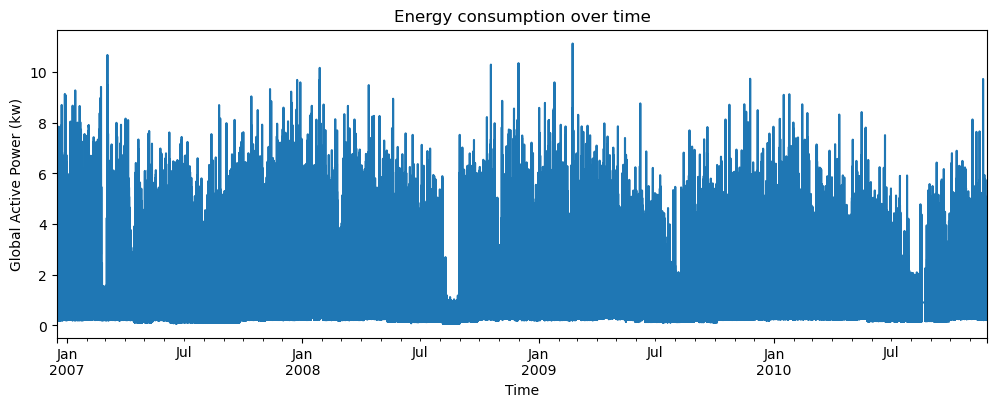

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
df["Global_active_power"].plot()
plt.title("Energy consumption over time")
plt.xlabel("Time")
plt.ylabel("Global Active Power (kw)")
plt.show()

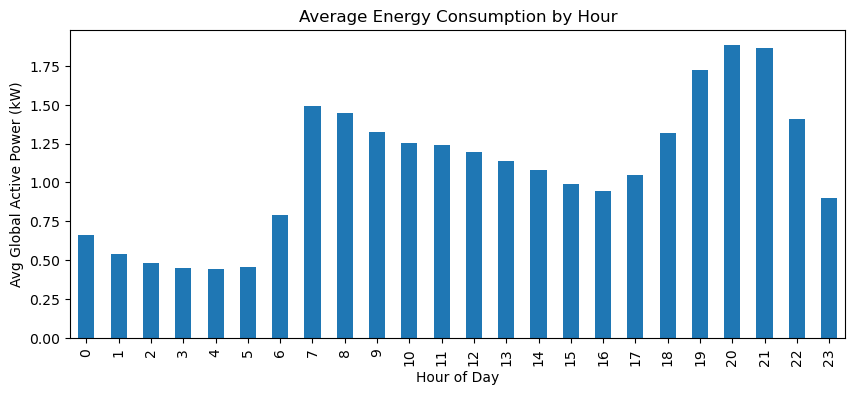

In [20]:
hourly_avg = df.groupby("hour")["Global_active_power"].mean()

plt.figure(figsize=(10,4))
hourly_avg.plot(kind="bar")
plt.title("Average Energy Consumption by Hour")
plt.xlabel("Hour of Day")
plt.ylabel("Avg Global Active Power (kW)")
plt.show()

In [21]:
df.groupby("is_peak_hour")["Global_active_power"].mean()

is_peak_hour
0    0.940573
1    1.639209
Name: Global_active_power, dtype: float64

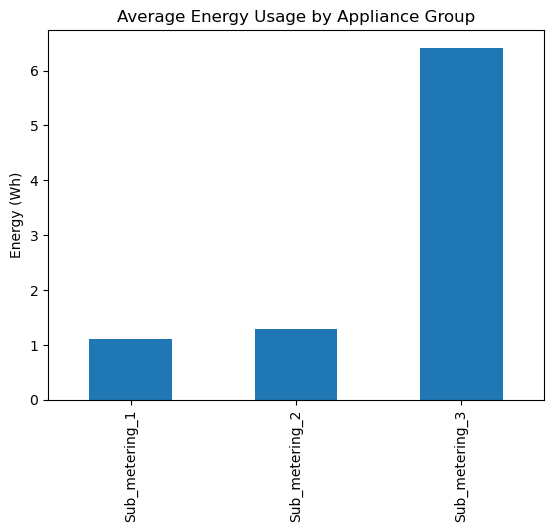

In [22]:
df[["Sub_metering_1", "Sub_metering_2", "Sub_metering_3"]].mean().plot(
    kind="bar",
    title="Average Energy Usage by Appliance Group"
)
plt.ylabel("Energy (Wh)")
plt.show()

In [19]:
X = df.drop("Global_active_power", axis=1)
y = df["Global_active_power"]

In [20]:
X

,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,hour,day,month,weekday,is_peak_hour
Datetime,,,,,,,,,,,
2006-12-16 17:24:00,0.418,234.84,18.4,0.0,1.0,17.0,17,16,12,5,0
2006-12-16 17:25:00,0.436,233.63,23.0,0.0,1.0,16.0,17,16,12,5,0
2006-12-16 17:26:00,0.498,233.29,23.0,0.0,2.0,17.0,17,16,12,5,0
2006-12-16 17:27:00,0.502,233.74,23.0,0.0,1.0,17.0,17,16,12,5,0
2006-12-16 17:28:00,0.528,235.68,15.8,0.0,1.0,17.0,17,16,12,5,0
...,...,...,...,...,...,...,...,...,...,...,...
2010-11-26 20:58:00,0.000,240.43,4.0,0.0,0.0,0.0,20,26,11,4,1
2010-11-26 20:59:00,0.000,240.00,4.0,0.0,0.0,0.0,20,26,11,4,1
2010-11-26 21:00:00,0.000,239.82,3.8,0.0,0.0,0.0,21,26,11,4,1


In [21]:
split = int(len(df)*0.8)
split

1660207

In [22]:
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

RANDOM FOREST REGRESSION

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(
    n_estimators=100,  #no. of decision trees
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

y_pred = rf.predict(X_test)

print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R2:", r2_score(y_test, y_pred))

MAE: 0.02124599199664253
RMSE 0.034230843203756786
R2: 0.9984829274083944


MAY BE DATA LEAKAGE HAPPENS 

We have to retrain the data by removing some field

In [ ]:
feature_cols = ["hour", "day", "month", "weekday", "is_peak_hour"]

X = df[feature_cols]
y = df["Global_active_power"]

In [25]:
X.head()

,hour,day,month,weekday,is_peak_hour
Datetime,,,,,
2006-12-16 17:24:00,17,16,12,5,0
2006-12-16 17:25:00,17,16,12,5,0
2006-12-16 17:26:00,17,16,12,5,0
2006-12-16 17:27:00,17,16,12,5,0
2006-12-16 17:28:00,17,16,12,5,0
